In [53]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ryanholbrook/car-or-truck")

print("Path to dataset files:", path)

Path to dataset files: /home/dnilson/.cache/kagglehub/datasets/ryanholbrook/car-or-truck/versions/1


In [15]:
path = '../data'

# 1) Data Preparation

In [16]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tf_keras
from tensorflow.keras.preprocessing import image_dataset_from_directory



# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    str(path) + '/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    str(path) + '/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [25]:
print(ds_train_.class_names)

['Car', 'Truck']


# 2) Download of model

In [17]:
# Download model pre-trained
import tensorflow_hub as hub

pretrained_base = hub.KerasLayer("https://www.kaggle.com/models/google/inception-v1/TensorFlow2/classification/2")

# 3) Attach Head #

Now that the base is defined to do the feature extraction, create a head of `Dense` layers to perform the classification, following this diagram:

<figure>
<img src="https://storage.googleapis.com/kaggle-media/learn/images/i5VU7Ry.png" alt="Diagram of the dense head.">
</figure>


In [18]:
model = tf_keras.Sequential([
    pretrained_base,
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(6, activation="relu"),
    tf_keras.layers.Dense(1, activation="sigmoid"),
])

# 4) Train

In [19]:
optimizer = tf_keras.optimizers.Adam(epsilon=0.01)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=35,
)

Epoch 1/35
80/80 [==============================] - 7s 61ms/step - loss: 0.5443 - binary_accuracy: 0.7471 - val_loss: 0.4380 - val_binary_accuracy: 0.8054
Epoch 2/35
80/80 [==============================] - 4s 55ms/step - loss: 0.4112 - binary_accuracy: 0.8163 - val_loss: 0.3995 - val_binary_accuracy: 0.8254
Epoch 3/35
80/80 [==============================] - 4s 55ms/step - loss: 0.3743 - binary_accuracy: 0.8325 - val_loss: 0.3894 - val_binary_accuracy: 0.8270
Epoch 4/35
80/80 [==============================] - 4s 54ms/step - loss: 0.3555 - binary_accuracy: 0.8394 - val_loss: 0.3836 - val_binary_accuracy: 0.8309
Epoch 5/35
80/80 [==============================] - 4s 52ms/step - loss: 0.3409 - binary_accuracy: 0.8491 - val_loss: 0.3807 - val_binary_accuracy: 0.8335
Epoch 6/35
80/80 [==============================] - 4s 52ms/step - loss: 0.3305 - binary_accuracy: 0.8530 - val_loss: 0.3749 - val_binary_accuracy: 0.8377
Epoch 7/35
80/80 [==============================] - 4s 53ms/step - los

# 5) Results

<Axes: >

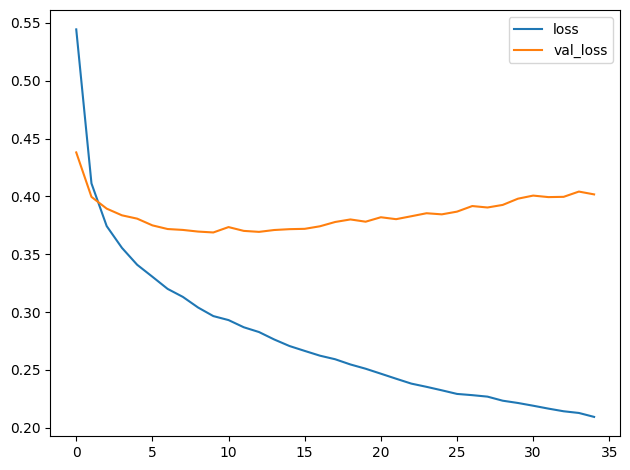

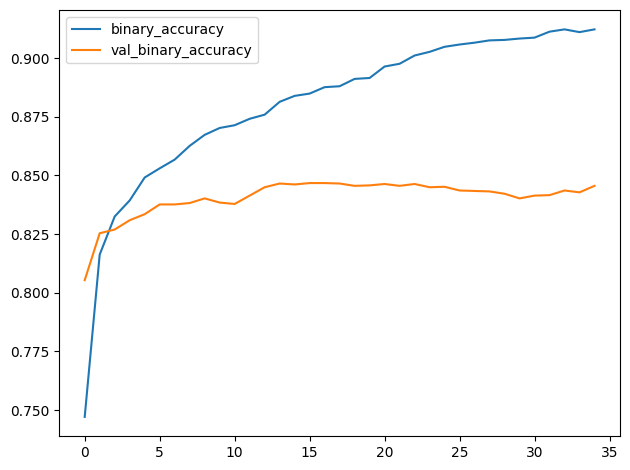

In [20]:
import pandas as pd

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [24]:
# Save model

model.save("../models/car_or_truck.h5")